In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
import string
from sklearn.model_selection import train_test_split

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/brandynewanek/data/main/Sarcasm.csv')

In [3]:
df.head()

,headlines,target
0,CNN Triumphs (At Least in Most Demographic Cat...,Non Sarcastic
1,"‘You Did The Best You Could,’ Says Iron Man Ac...",Sarcastic
2,New Emails Reveal Warm Relationship Between Ka...,Non Sarcastic
3,Donald Trump Jr. Gets Slammed Over Racist Birt...,Non Sarcastic
4,God Urges Rick Perry Not To Run For President,Sarcastic


In [4]:
df.tail()

,headlines,target
12501,Lapdogs of the Corporate Press,Non Sarcastic
12502,Annoying Coworker Precedes All Nouns With 'Qui...,Sarcastic
12503,Report: North Dakota Leads Nation In Parking A...,Sarcastic
12504,The Election Night Drinking Game: HyperVocal E...,Non Sarcastic
12505,Conjoined Twin Hogging Kidney,Sarcastic


Target Balance


<Axes: xlabel='target'>

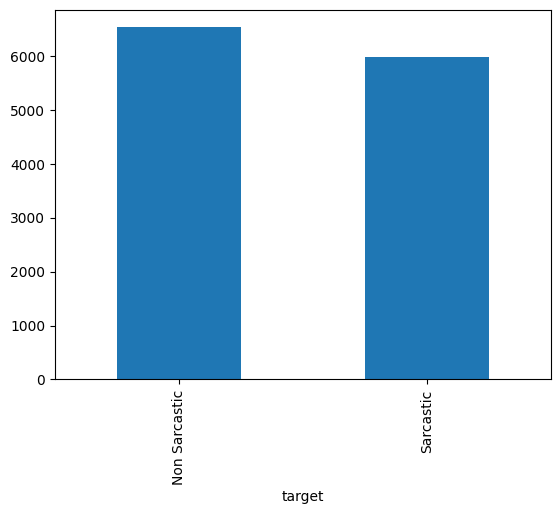

In [5]:
df['target'].value_counts().plot(kind='bar')

Non-sarcastic Comments

In [6]:
df[df['target']=='Non Sarcastic']['headlines'].iloc[29]


"Sen. Kamala Harris' Guide To Protesting The Health Care Bill"

In [7]:
df[df['target']=='Non Sarcastic']['headlines'].iloc[4]

"CNN Anchor Calls Obama Protester 'Rude' And 'Crazy'"

In [8]:
df[df['target']=='Non Sarcastic']['headlines'].iloc[30]


"Republic Flight Makes Emergency Landing In NY After Passenger's 'Erratic Behavior'"

In [9]:
df[df['target']=='Non Sarcastic']['headlines'].iloc[3]

'Global Aid Pours into Haiti'

Scarcastic comments

In [10]:
df[df['target']=='Sarcastic']['headlines'].iloc[15]


'Mayor Of Phoenix Apologizes For Naming Berlin Germany Of 1941 As Sister City'

In [11]:
df[df['target']=='Sarcastic']['headlines'].iloc[17]


'Report: Average American Feels Comfortable In Own Skin For Only 6% Of Day'

In [12]:
df[df['target']=='Sarcastic']['headlines'].iloc[2]


'Federal Prisons Reinstitute Executions By Lethal Inflation'

In [13]:
df[df['target']=='Sarcastic']['headlines'].iloc[3]


'Soldier Back Home From Serving At Mexico Border Still Having Nightmares About Being Used As Political Prop'

In [14]:
df[df['target']=='Non Sarcastic']['headlines'].iloc[43]


'Who Needs Journalism?'

Preprocessing

convert everythong to lowercase

In [15]:
df['headlines']=df['headlines'].str.lower()

Remove puncutaions and stop words

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
stop_words=nltk.corpus.stopwords.words('english')
punct=string.punctuation

In [18]:
df['headlines']=df['headlines'].replace(stop_words,'')
df['headlines']=df['headlines'].replace(punct,'')

In [19]:
def to_binary(x):
  if x =='Sarcastic':
    return 1
  else:
    return 0

In [20]:
df['target']=df['target'].apply(to_binary)

In [21]:
df.columns

Index(['headlines', 'target'], dtype='object')

In [22]:
input=df['headlines']
output=df['target']

In [23]:
input_train, input_test, output_train, output_test = train_test_split(input, output, test_size=0.3, random_state=42)

In [24]:
num_words = 10000

In [25]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = num_words,
                                                  filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~',
                                                  oov_token = '<oov>')

In [26]:
tokenizer.fit_on_texts(input_train)

In [27]:
word_index=tokenizer.word_index

In [28]:
reverse_word_index = dict([ (v,k) for (k,v) in word_index.items ()])

In [29]:
vocab_size = len(word_index)

In [30]:
vocab_size

16528

In [31]:
input_train = tokenizer.texts_to_sequences(input_train)
input_test = tokenizer.texts_to_sequences(input_test)

In [32]:
max_len = max([len(s) for s in input_train])
max_len

39

In [33]:
input_train = tf.keras.utils.pad_sequences(input_train, padding = 'pre', maxlen=max_len)
input_test = tf.keras.utils.pad_sequences(input_test, padding = 'pre', maxlen=max_len)

Modeling

In [34]:

embd_dim = 128  # Example value for the embedding dimension
rec_nns = 64  # Example value for the number of units in the LSTM layer
rec_act = 'tanh'  # Example activation function for the LSTM layer

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(num_words, embd_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rec_nns, activation=rec_act)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 39, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable params: 1378945 (5.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
history = model.fit(input_train, output_train,
                    epochs = 5,
                    validation_data = (input_test, output_test))

Epoch 1/5
274/274 [==============================] - 40s 90ms/step - loss: 0.3485 - accuracy: 0.8377 - val_loss: 0.2475 - val_accuracy: 0.8993
Epoch 2/5
274/274 [==============================] - 24s 89ms/step - loss: 0.1075 - accuracy: 0.9622 - val_loss: 0.2507 - val_accuracy: 0.8993
Epoch 3/5
274/274 [==============================] - 25s 93ms/step - loss: 0.0386 - accuracy: 0.9888 - val_loss: 0.3187 - val_accuracy: 0.8985
Epoch 4/5
274/274 [==============================] - 26s 96ms/step - loss: 0.0162 - accuracy: 0.9950 - val_loss: 0.4455 - val_accuracy: 0.8915
Epoch 5/5
274/274 [==============================] - 23s 83ms/step - loss: 0.0151 - accuracy: 0.9960 - val_loss: 0.4095 - val_accuracy: 0.8937


<Axes: >

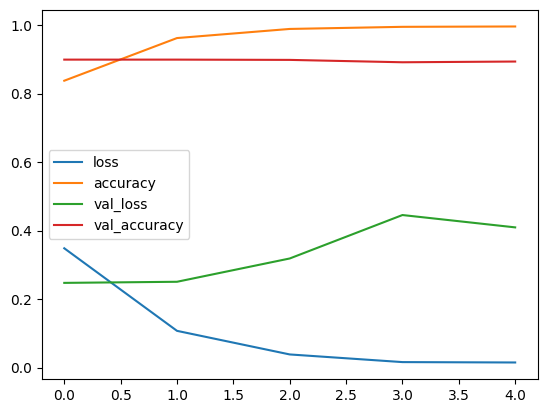

In [36]:
pd.DataFrame(history.history).plot()

In [41]:
def preprocess_sentence(sentence):
    # Convert to lowercase
    sentence = sentence.lower()

    # Remove punctuation and stop words
    sentence = ''.join([char for char in sentence if char not in string.punctuation])
    sentence = ' '.join([word for word in sentence.split() if word not in stop_words])

    return sentence

def predict_sarcasm(sentence):
    # Preprocess the input sentence
    preprocessed_sentence = preprocess_sentence(sentence)

    # Tokenize the preprocessed sentence
    tokenized_sentence = tokenizer.texts_to_sequences([preprocessed_sentence])

    # Pad the tokenized sentence
    padded_sentence = tf.keras.preprocessing.sequence.pad_sequences(tokenized_sentence,
                                                                    padding='pre',
                                                                    maxlen=max_len)

    # Make prediction
    prediction = model.predict(padded_sentence)[0][0]

    # Determine the sarcasm label based on prediction threshold (e.g., 0.5)
    sarcasm_label = 'Sarcastic' if prediction >= 0.5 else 'Non-Sarcastic'

    return sarcasm_label, prediction

# Example usage
input_sentence = "He ate like there was no tomorrow"
sarcasm_label, sarcasm_probability = predict_sarcasm(input_sentence)
print(f"Sarcasm Label: {sarcasm_label}")
print(f"Sarcasm Probability: {sarcasm_probability}")



1/1 [==============================] - 0s 196ms/step
Sarcasm Label: Sarcastic
Sarcasm Probability: 0.9661017060279846


In [38]:
model.save("sd.keras")

In [40]:
!pip install gradio

import ipywidgets as widgets
from IPython.display import display
import gradio as gr

# def predict(text):
#     """
#     This function predicts the toxicity of the comment passed.
#     """
#     predictions = model.predict([text])
#     result = str({column_name: prediction for column_name, prediction in zip(df.columns[2:], np.squeeze(predictions))})
#     output_string = f"Prediction for '{text}' ===> Results: {result}"
#     return output_string

# interact(predict, text=Textarea(value='', placeholder='Type your text here', description='Text:'))

input_text = gr.Textbox(lines=2, label="Enter your sentence...")
output_text = gr.Textbox(label="Sarcasm Prediction")

def predict(input_sentence):
    sarcasm_label, sarcasm_probability = predict_sarcasm(input_sentence)
    return f"Sarcasm Label: {sarcasm_label}, Sarcasm Probability: {sarcasm_probability:.2f}"

iface = gr.Interface(fn=predict, inputs=input_text, outputs=output_text, title="Sarcasm Detection")
iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://bf279e8e493cff1518.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
